# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value" ICML 2023 , using pyDVL.
https://proceedings.mlr.press/v202/kwon23e.html

The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms computes data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std, plot_best_worst, plot_best_worst_class_imbalance, compute_best_worst_scores, plot_methods_linreg
from pydvl.value.result import ValuationResult

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
import pandas as pd

# Specify the URL of the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Specify the column names
column_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

# Specify the data types for each column
data_types = {
    "age": int,
    "workclass": "category",
    "fnlwgt": int,
    "education": "category",
    "education-num": int,
    "marital-status": "category",
    "occupation": "category",
    "relationship": "category",
    "race": "category",
    "sex": "category",
    "capital-gain": int,
    "capital-loss": int,
    "hours-per-week": int,
    "native-country": "category",
    "income": "category",
}

# Load the dataset into a pandas DataFrame
data_adult = pd.read_csv(
    url,
    names=column_names,
    sep=",\s*",
    engine="python",
    na_values="?",
    dtype=data_types,
    #nrows=2000,
)

# Drop categorical columns
data_adult = data_adult.drop(
    columns=[
        "workclass",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "native-country",
    ]
)

data_adult = data_adult.sample(frac=1)
# Display the first few rows of the dataframe
print(data_adult.head())
data = Dataset.from_arrays(
    X=data_adult.drop(columns=["income"]).values,
    y=data_adult.loc[:, "income"].cat.codes.values,
)

       age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
7482    59  192983              9             0             0              40   
1319    48   55237             13             0             0              45   
31080   32  194740             13             0          1902              40   
15537   28  114053             10             0             0              30   
26294   27  134566              9             0             0              40   

      income  
7482   <=50K  
1319    >50K  
31080   >50K  
15537  <=50K  
26294  <=50K  


In [3]:

#model = KNeighborsClassifier(n_neighbors=5)
model = DecisionTreeClassifier(max_depth=5,)
#model = LogisticRegression()
utility = Utility(model, data, Scorer("balanced_accuracy", default=0.0))

# Base estimator

In [4]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF

In [5]:

scorer = Scorer("balanced_accuracy", default=0.0)

dict_utilities = {}
#utility = Utility(KNeighborsClassifier(n_neighbors=5), data, scorer)
#dict_utilities["KNN"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=2,), data, scorer)
dict_utilities["DecisionTreeShallow"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=20,), data, scorer)
dict_utilities["DecisionTreeDeep"] = utility
#utility = Utility(MLPClassifier(), data, scorer)
#dict_utilities["MLPClassifier"] = utility
utility = Utility(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), data, scorer)
dict_utilities["RandomForest"] = utility
#utility = Utility(AdaBoostClassifier(), data, scorer)
#dict_utilities["AdaBoost"] = utility
#utility = Utility(LGBMClassifier(verbose= -1), data, scorer)
#dict_utilities["LGBM"] = utility

dict_utilities.keys()

dict_keys(['DecisionTreeShallow', 'DecisionTreeDeep', 'RandomForest'])

In [ ]:

scorer = Scorer("balanced_accuracy", default=0.0)

dict_utilities = {}
utility = Utility(KNeighborsClassifier(n_neighbors=5), data, scorer)
dict_utilities["KNN"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=2,), data, scorer)
dict_utilities["DecisionTreeShallow"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=20,), data, scorer)
dict_utilities["DecisionTreeDeep"] = utility
utility = Utility(LogisticRegression(), data, scorer)
dict_utilities["LogisticRegression"] = utility
utility = Utility(GaussianNB(), data, scorer)
dict_utilities["GaussianNB"] = utility
utility = Utility(MLPClassifier(), data, scorer)
dict_utilities["MLPClassifier"] = utility
utility = Utility(RandomForestClassifier(max_depth=5, n_estimators=10), data, scorer)
dict_utilities["RandomForest"] = utility
utility = Utility(AdaBoostClassifier(), data, scorer)
dict_utilities["AdaBoost"] = utility
utility = Utility(LGBMClassifier(verbose= -1), data, scorer)
dict_utilities["LGBM"] = utility

dict_utilities.keys()

# Fix OOB parameters

In [6]:
def oob_func(utility, model_name):
    return(compute_data_oob(dict_utilities[model_name], n_est=100, max_samples=0.4, progress=False))
kwargs_list = [{"model_name":m} for m in dict_utilities.keys()]

In [7]:
area_under_curve_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
area_under_curve_worse = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))

In [8]:
def compute_random_baseline_best_worst_mean(n_iter, utility_eval, removal_percentages):
    random_vals = [ValuationResult.from_random(size=len(utility.data)) for _ in range(n_iter)]
    best_random_score = [compute_removal_score(u=utility,
                                            values=vals,
                                            percentages=removal_percentages,
                                            remove_best=True,) for vals in random_vals]
    df_random_best = pd.DataFrame(best_random_score)
    df_random_best = df_random_best.mean()

    worst_random_score = [compute_removal_score(u=utility_eval,
                                            values=vals,
                                            percentages=removal_percentages,
                                            remove_best=False,) for vals in random_vals]
    df_random_worst = pd.DataFrame(worst_random_score)
    df_random_worst = df_random_worst.mean()
    return(df_random_best, df_random_worst)

In [9]:
n_iter = 10
removal_percentages = np.arange(0, 0.99, 0.01)

area_under_curve_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
area_under_curve_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
diff_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
diff_random_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
single_best_gain_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
single_best_gain_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
max_accuracy_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
max_accuracy_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
idxmax_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
idxmax_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))

for k in kwargs_list:
    model_name = k["model_name"]
    utility_eval = dict_utilities[model_name]
    df_random_best, df_random_worst = compute_random_baseline_best_worst_mean(n_iter, utility_eval, removal_percentages)
    best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list,f_name="", return_values=True)
    best_scores_df.loc[:,"method_name"] = best_scores_df.loc[:,"method_name"].apply(lambda x: "_".join(x.split("_")[1:]))
    worst_scores_df.loc[:,"method_name"] = worst_scores_df.loc[:,"method_name"].apply(lambda x: "_".join(x.split("_")[1:]))
    df_mean_best = best_scores_df.groupby("method_name").mean()
    df_mean_worst = worst_scores_df.groupby("method_name").mean()

    area_under_curve_best.loc[:,model_name] = df_mean_best.sum(axis=1)/len(removal_percentages)
    area_under_curve_worst.loc[:,model_name] = df_mean_worst.sum(axis=1)/len(removal_percentages)

    best_compare_random = df_mean_best.apply(lambda row: np.array(row.values < df_random_best, dtype=int), axis=1)
    worst_compare_random = df_mean_worst.apply(lambda row: np.array(row.values > df_random_worst, dtype=int), axis=1)
    percent_above_random_best.loc[:,model_name] = best_compare_random.apply(lambda x: np.mean(x))
    percent_above_random_worst.loc[:,model_name] = worst_compare_random.apply(lambda x: np.mean(x))

    diff_random_best.loc[:,model_name] = df_mean_best.apply(lambda row: sum(np.array(row.values - df_random_best, dtype=float)* np.array(row.values < df_random_best, dtype=int)), axis=1)
    diff_random_worst.loc[:,model_name] = df_mean_worst.apply(lambda row: sum(np.array(row.values - df_random_worst, dtype=float)* np.array(row.values > df_random_worst, dtype=int)), axis=1)

    single_best_gain_best.loc[:,model_name] = df_mean_best.apply(lambda row: min(np.array(row.values - df_random_best, dtype=float)), axis=1)
    single_best_gain_worst.loc[:,model_name] = df_mean_worst.apply(lambda row: max(np.array(row.values - df_random_worst, dtype=float)), axis=1)

    max_accuracy_best.loc[:,model_name] = df_mean_best.apply(lambda row: max(row.values), axis=1)
    max_accuracy_worst.loc[:,model_name] = df_mean_worst.apply(lambda row: max(row.values), axis=1)

    idxmax_best.loc[:,model_name] = df_mean_best.idxmax(axis=1)
    idxmax_worst.loc[:,model_name] = df_mean_worst.idxmax(axis=1)

### Visualize inconsistencies in ranking

In [19]:

for k in kwargs_list:
    model_name = k["model_name"]
    print(model_name)

DecisionTreeShallow
DecisionTreeDeep
RandomForest


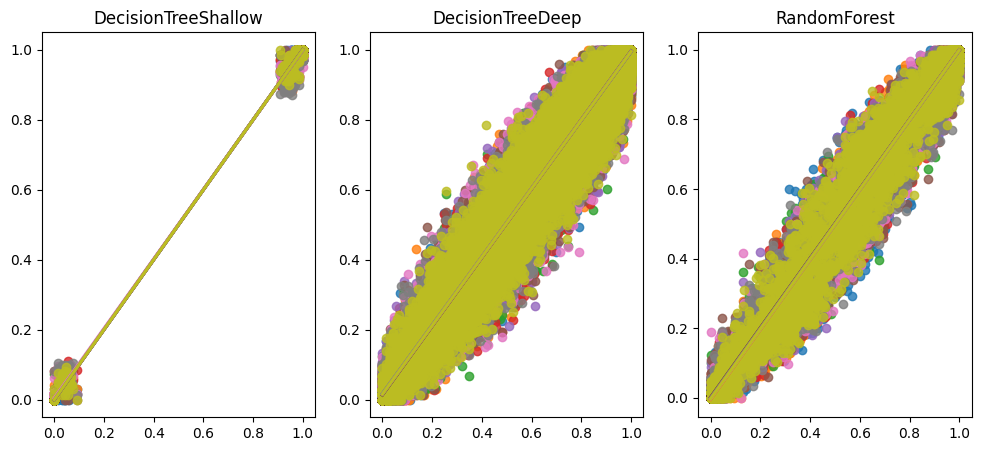

In [21]:
fig, ax = plt.subplots(nrows= 1, ncols=len(kwargs_list), figsize=[4*len(kwargs_list),5])
all_df = []
for j, k in enumerate(kwargs_list):
    model_name = k["model_name"]
    vals_i = [[x.values[[list(x.indices).index(i)]][0] for i in range(len(x.indices))] for x in all_values[model_name]]
    for i in range(1,len(vals_i)):
        sns.regplot(x=vals_i[0], y=vals_i[i], ax=ax[j])
    
    df = pd.DataFrame(vals_i)
    df.loc[:,"model_name"] = model_name
    all_df.append(df)
    ax[j].set_title(model_name)

all_df = pd.concat(all_df)

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

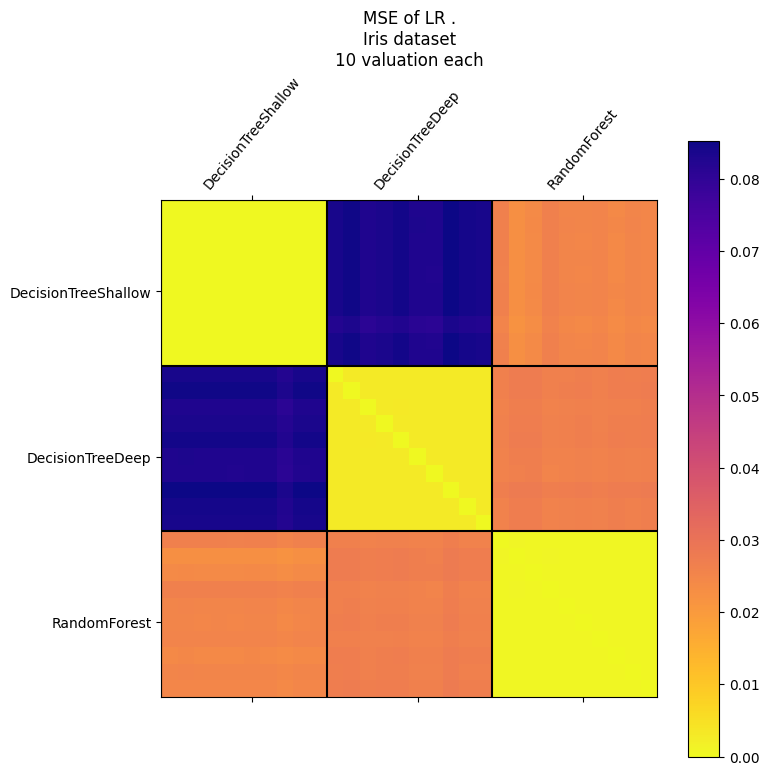

In [23]:
res = np.zeros((len(all_df),len(all_df)))
for i in range(len(all_df)):
    for j in range(len(all_df)):
        x = all_df.drop(columns=["model_name"]).iloc[i].values.reshape(-1,1)
        y = all_df.drop(columns=["model_name"]).iloc[j].values.reshape(-1,1)
        res[i,j] = mean_squared_error(LinearRegression().fit(X=x, y=y).predict(x), y)
        res[j,i] = res[i,j]
        #print(res[i,j])
        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8,8])
im = ax.matshow(res, cmap="plasma_r")
offset=0.5
for i in range(len(kwargs_list)):
    plt.hlines(xmin=-offset, xmax=len(all_df)-offset, y=i*n_iter-offset, color="black")
    plt.vlines(ymin=-offset, ymax=len(all_df)-offset, x=i*n_iter-offset, color="black")

ticks_loc = [i for i in range(0+int(len(all_df)/len(kwargs_list)/2), len(all_df), int(len(all_df)/len(kwargs_list)))]
model_names = [k["model_name"] for j, k in enumerate(kwargs_list)]
plt.xticks( ticks_loc, model_names, rotation=50)
plt.yticks( ticks_loc, model_names)
plt.colorbar(im, ax=ax)
plt.title(f"MSE of LR .\nIris dataset\n{n_iter} valuation each")
plt.show()

In [27]:
from scipy.stats import kendalltau

In [32]:
all_df = all_df.rename(columns={"model_name":"name"})
all_df

0         1         2         3         4         5         6  \
0  0.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  0.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
3  0.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
4  0.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
5  0.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
6  0.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
7  0.014925  1.000000  1.000000  1.000000  0.985294  1.000000  1.000000   
8  0.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
9  0.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
0  0.733333  0.876923  0.985507  0.818182  0.630137  0.986667  0.930556   
1  0.686567  0.968254  1.000000  0.825397  0.671642  1.000000  0.818182   
2  0.738462  0.951613  1.000000  0.894737  0.782609  0.971429  0.932203   
3  0.785714  0.922078  1.000000  0.809524  0.684932  0.971429  0.966102   
4  0.796610  0.925373  1.000000  0.826667  0.818182  0.986301  0.878788   
5  0.828125  0.935484  1.000000  0.875000  0.724638  1.000000  0.926471   
6  0.712121  0.907895  1.000000  0.826087  0.656250  1.000000  0.868852   
7  0.855072  0.900000  1.000000  0.831169  0.666667  1.000000  0.880597   
8  0.730159  0.918033  1.000000  0.852941  0.836066  0.982456  0.805970   
9  0.685714  0.830986  1.000000  0.876712  0.681818  1.000000  0.924242   
0  0.414286  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  0.250000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.322034  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
3  0.282051  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
4  0.289855  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
5  0.303030  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
6  0.238095  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
7  0.257576  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
8  0.343750  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
9  0.295775  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

          7         8         9  ...     26039     26040     26041     26042  \
0  0.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  0.000000   
1  0.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  0.000000   
2  0.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  0.000000   
3  0.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  0.000000   
4  0.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  0.000000   
5  0.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  0.000000   
6  0.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  0.000000   
7  0.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  0.000000   
8  0.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  0.000000   
9  0.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  0.000000   
0  0.438596  0.548387  0.746269  ...  1.000000  0.924242  0.955224  0.721311   
1  0.449275  0.580645  0.634921  ...  1.000000  0.902778  0.971429  0.727273   
2  0.471429  0.439394  0.811594  ...  0.985075  0.932432  0.969697  0.661972   
3  0.459459  0.493151  0.753623  ...  1.000000  0.865672  0.969231  0.723077   
4  0.389831  0.459016  0.783784  ...  1.000000  0.888889  0.985294  0.632353   
5  0.390625  0.476923  0.661765  ...  1.000000  0.960526  0.985507  0.660714   
6  0.433333  0.515625  0.661765  ...  1.000000  0.955224  0.929577  0.766234   
7  0.516129  0.537313  0.712329  ...  0.985294  0.898305  0.938462  0.657895   
8  0.400000  0.475410  0.753846  ...  0.964912  0.960000  0.935484  0.671642   
9  0.432836  0.551282  0.753425  ...  1.000000  0.937500  0.984615  0.600000   
0  0

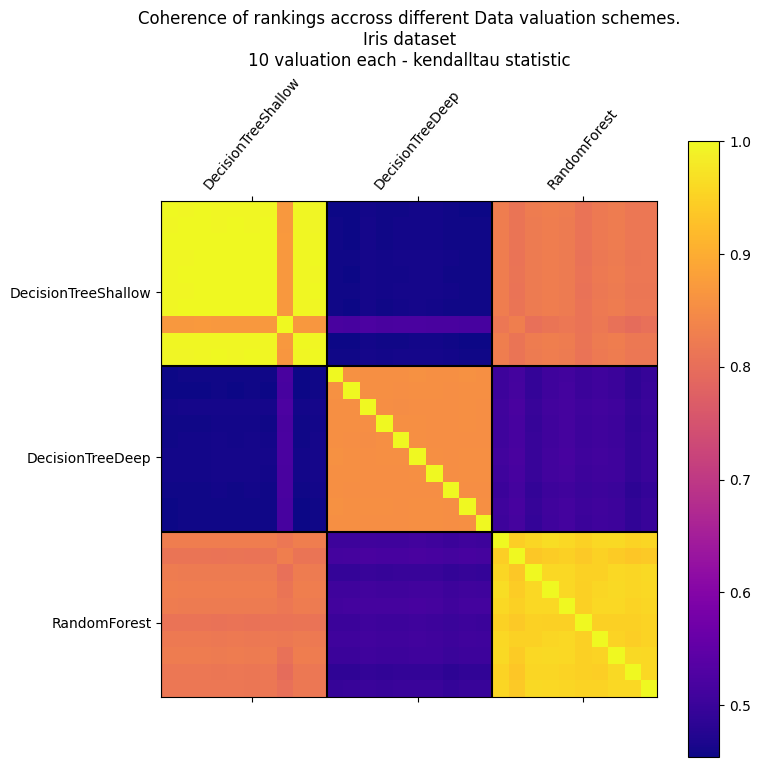

In [33]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8,8])
im = ax.matshow([[ kendalltau(all_df.drop(columns=["name"]).iloc[i], all_df.drop(columns=["name"]).iloc[j]).statistic for i in range(len(all_df))]for j in range(len(all_df))],
           cmap="plasma")
offset=0.5
for i in range(all_df.name.nunique()):
    plt.hlines(xmin=-offset, xmax=len(all_df)-offset, y=i*n_iter-offset, color="black")
    plt.vlines(ymin=-offset, ymax=len(all_df)-offset, x=i*n_iter-offset, color="black")

ticks_loc = [i for i in range(0+int(len(all_df)/all_df.name.nunique()/2), len(all_df), int(len(all_df)/all_df.name.nunique()))]
model_names = all_df.name.unique()
plt.xticks( ticks_loc, model_names, rotation=50)
plt.yticks( ticks_loc, model_names)
plt.colorbar(im, ax=ax)
plt.title(f"Coherence of rankings accross different Data valuation schemes.\nIris dataset\n{n_iter} valuation each - kendalltau statistic")
plt.show()

In [10]:

        #names = [str(metric)+f"_{col}"    for col in ["DTshal", "DTdeep", "RF"] for metric in all_metrics_names]

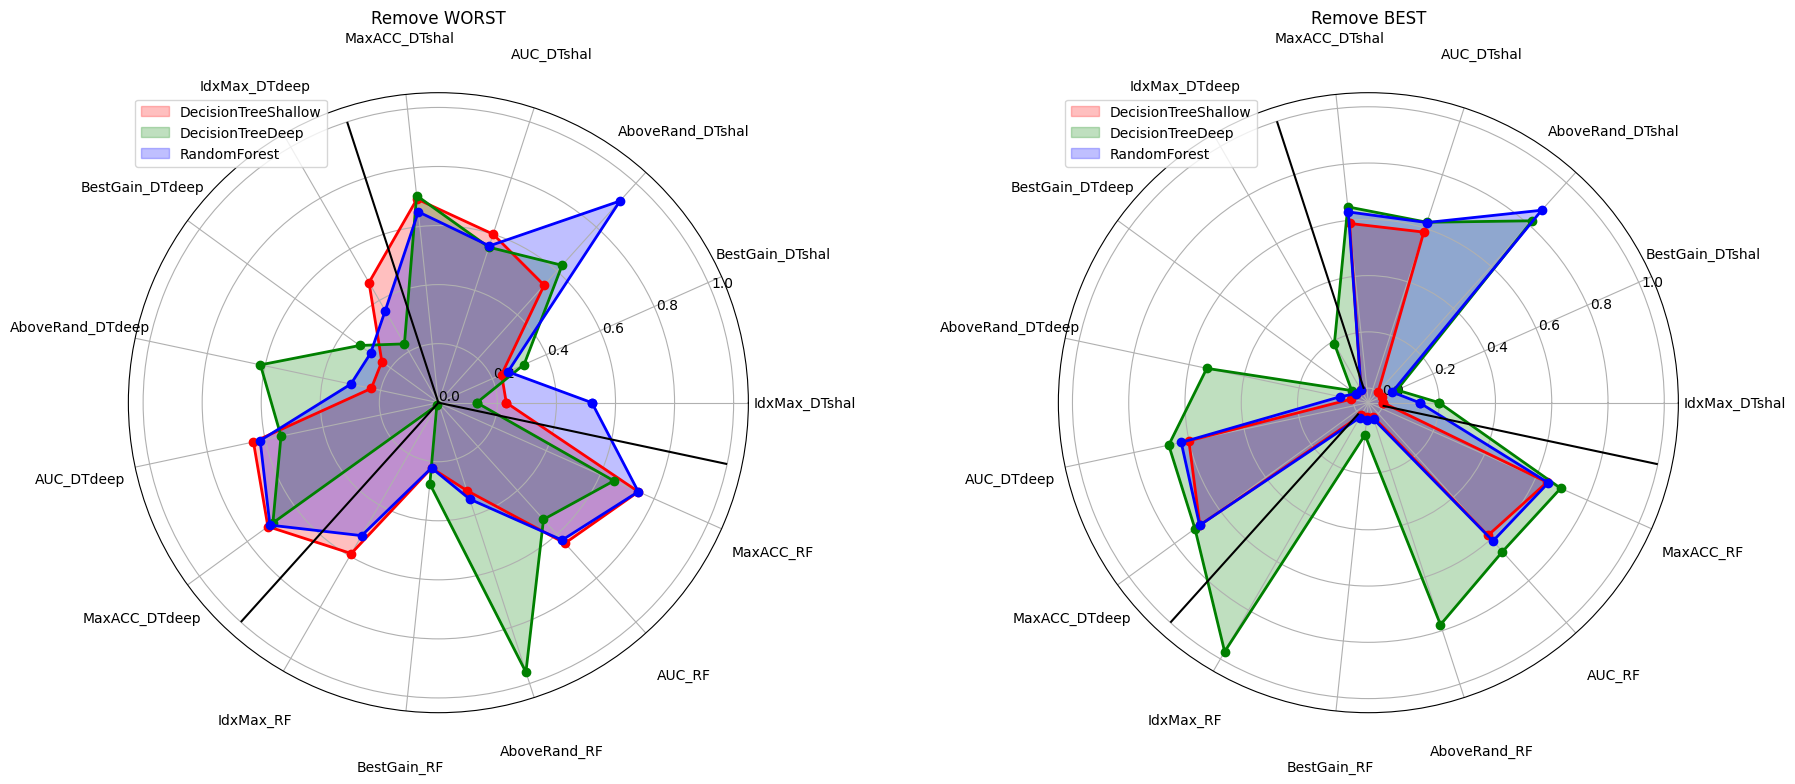

In [11]:
all_metrics_names = ["AUC", "AboveRand", "BestGain", "MaxACC", "IdxMax"]
all_metrics_worst = [ idxmax_worst, single_best_gain_worst, percent_above_random_worst, area_under_curve_worst , max_accuracy_worst]
all_metrics_best = [ idxmax_best, -single_best_gain_best, percent_above_random_best, area_under_curve_best , max_accuracy_best]

all_metrics_names = ["IdxMax", "BestGain", "AboveRand","AUC",  "MaxACC", ]


fig = plt.figure(figsize = [20,20])
for name, all_metrics, ax in zip(["Remove WORST", "Remove BEST"], [all_metrics_best, all_metrics_worst], [fig.add_subplot(121, polar=True), fig.add_subplot(122, polar=True)]):

    for color, chosen_dataval in zip(['r','g','b'],idxmax_best.columns ):
        values = [metric.loc[chosen_dataval, col]    for col in  idxmax_best.columns for metric in all_metrics]
        names = [str(metric)+f"_{col}"    for col in ["DTshal", "DTdeep", "RF"] for metric in all_metrics_names]



        angles = np.linspace(0, 2*np.pi, len(values), endpoint=False)

        values = np.concatenate((values,[values[0]]))
        angles = np.concatenate((angles,[angles[0]]))
        
        ax.vlines([0], 0, [0], colors='black', zorder=3)
        ax.plot(angles, values, color+'o-', linewidth=2)
        ax.fill(angles, values,color=color, alpha=0.25, label=chosen_dataval)
        ax.set_thetagrids(angles[:-1] * 180/np.pi, names)
        ax.tick_params(pad=30)
        ax.set_yticks(np.linspace(0,1,6))
        ax.set_title(name)
        ax.grid(True)
    for ang in np.linspace(0,2*np.pi, len(idxmax_best.columns), endpoint=False):
        ax.vlines([0,ang-(2*np.pi/len(idxmax_best.columns)/(len(all_metrics_names)))/2], 0, [0,1], colors='black', zorder=3)

    ax.legend(loc=2)


plt.subplots_adjust(wspace=0.5)

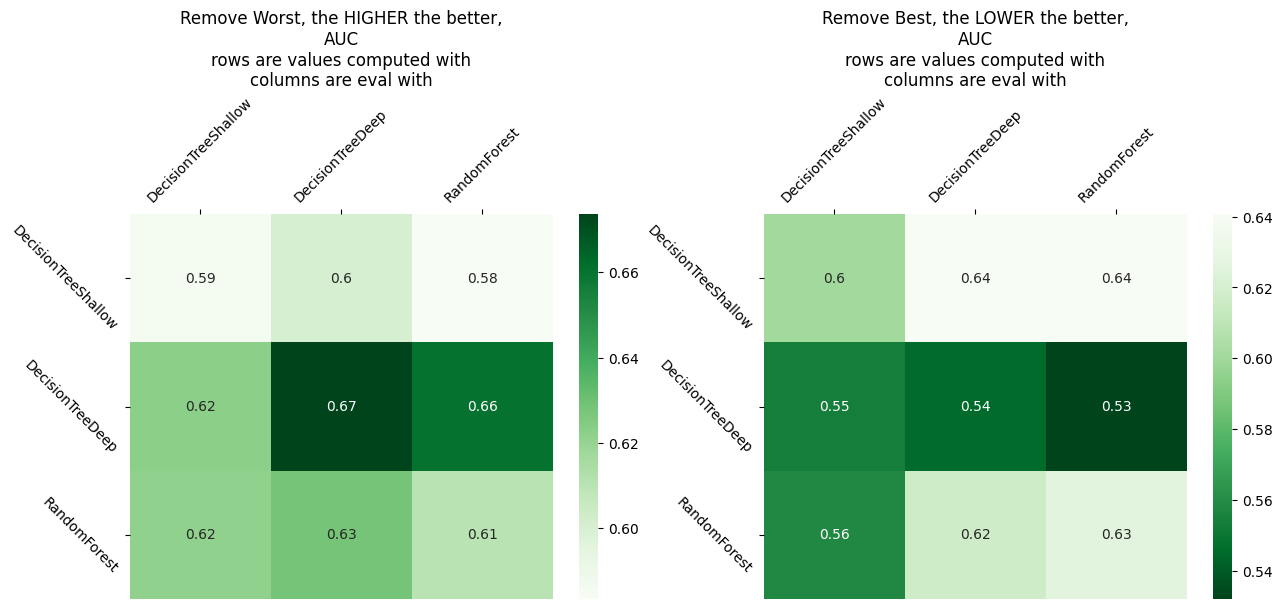

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)

sns.heatmap(area_under_curve_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap="Greens")
sns.heatmap(area_under_curve_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap="Greens_r")

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst, the HIGHER the better,\nAUC\nrows are values computed with\ncolumns are eval with")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best, the LOWER the better,\nAUC\nrows are values computed with\ncolumns are eval with")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)

plt.savefig("./figures/auc.png", bbox_inches='tight')

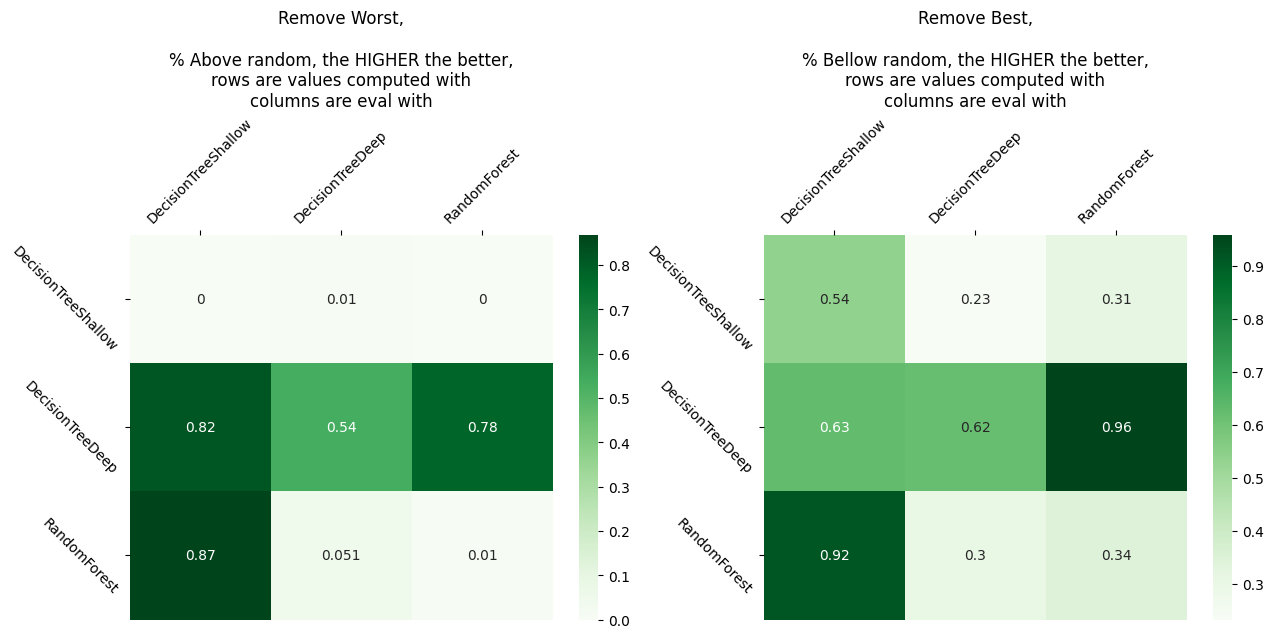

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)


sns.heatmap(percent_above_random_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap = "Greens")
sns.heatmap(percent_above_random_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap = "Greens")

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst,\n\n% Above random, the HIGHER the better,\nrows are values computed with\ncolumns are eval with")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()model_name
ax[1].set_title("Remove Best,\n\n% Bellow random, the HIGHER the better,\nrows are values computed with\ncolumns are eval with")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)

plt.savefig("./figures/percent_above_random.png", bbox_inches='tight')

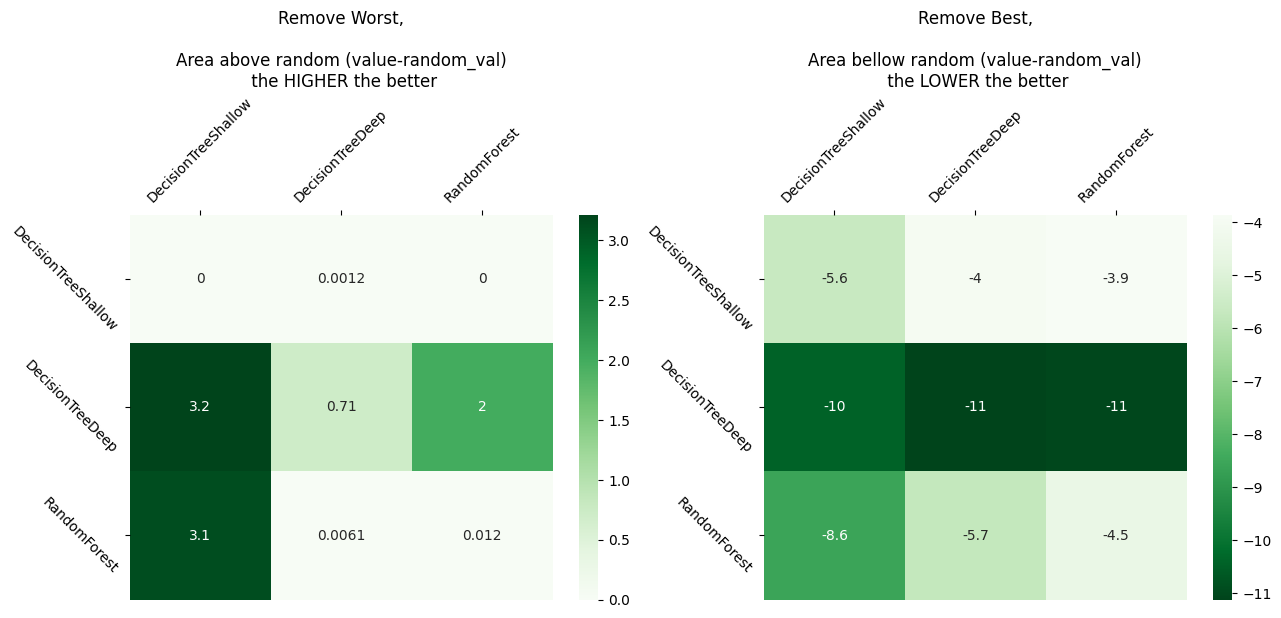

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)

sns.heatmap(diff_random_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap = 'Greens')
sns.heatmap(diff_random_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap = 'Greens_r')

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst,\n\nArea above random (value-random_val)\n the HIGHER the better")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best,\n\nArea bellow random (value-random_val)\n the LOWER the better")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)
plt.savefig("./figures/diff_random.png", bbox_inches='tight')

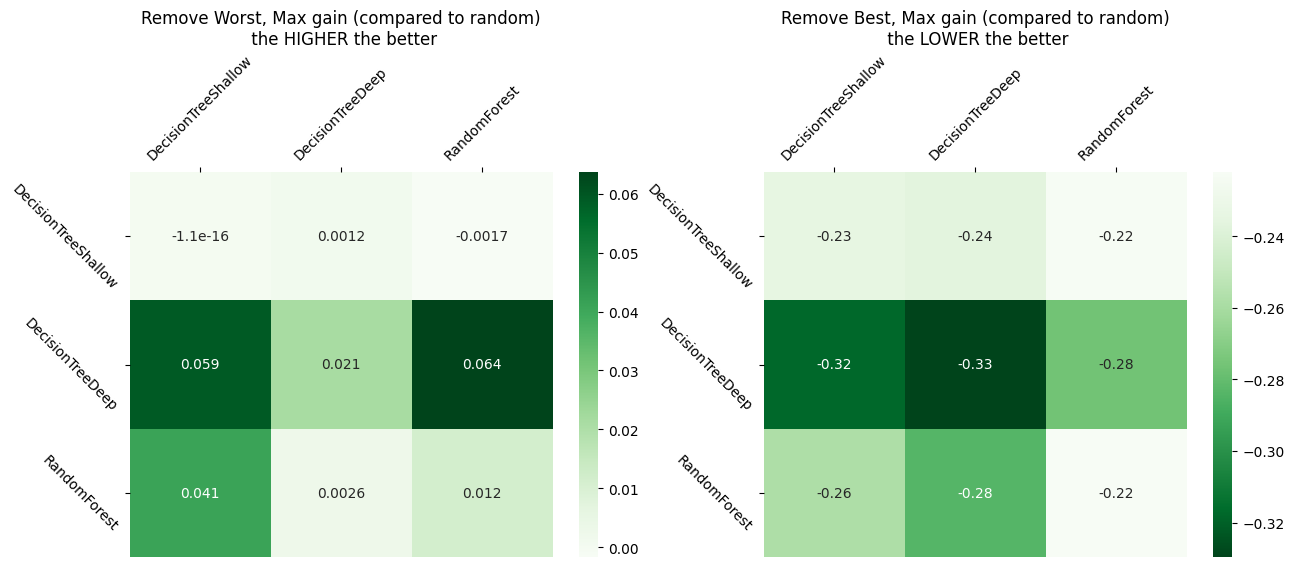

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)

sns.heatmap(single_best_gain_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap = 'Greens')
sns.heatmap(single_best_gain_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap = 'Greens_r')

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst, Max gain (compared to random)\n the HIGHER the better")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best, Max gain (compared to random)\n the LOWER the better")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)

plt.savefig("./figures/best_gain.png", bbox_inches='tight')

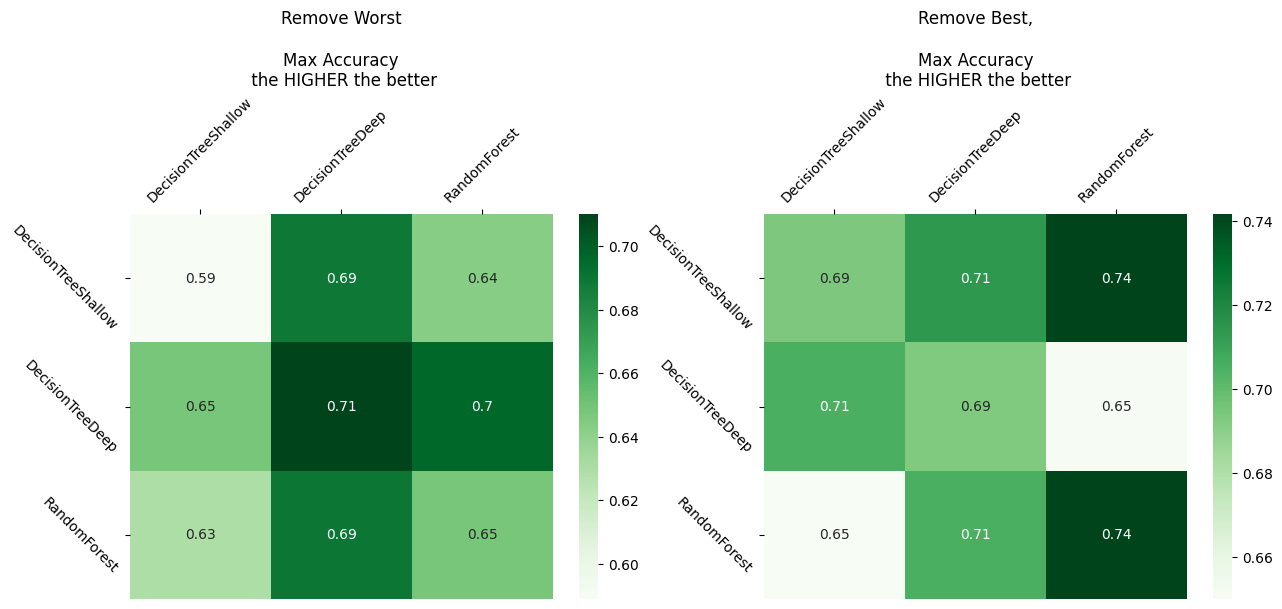

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)
sns.heatmap(max_accuracy_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap = 'Greens')
sns.heatmap(max_accuracy_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap = 'Greens')

ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best,\n\nMax Accuracy\n the HIGHER the better")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)
ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst\n\nMax Accuracy\n the HIGHER the better")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
plt.savefig("./figures/best_gain.png", bbox_inches='tight')

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])max_accuracy_worst
col_order = list(area_under_curve_best.columns)

sns.heatmap(idxmax_worst.loc[col_order,col_order], annot=True,ax=ax[0], cmap = 'Greens')
sns.heatmap(idxmax_best.loc[col_order,col_order], annot=True,ax=ax[1], cmap = 'Greens')

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Worst\n\nIdx Max Accuracy\n the HIGHER the better")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()
ax[1].set_title("Remove Best,\n\nIdx Max Accuracy\n the HIGHER the better")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)

plt.savefig("./figures/best_gain.png", bbox_inches='tight')

SyntaxError: invalid syntax (2386199075.py, line 1)

# Validate previous results

In [ ]:
def oob_func_test(utility, _):
    return(compute_data_oob(utility, n_est=30, max_samples=0.8, progress=False))

In [ ]:
dict_utilities.keys()

dict_keys(['DecisionTreeShallow', 'DecisionTreeDeep', 'RandomForest'])

In [ ]:
model = LogisticRegression()
utility = dict_utilities["DecisionTreeDeep"]
utility_eval = dict_utilities["DecisionTreeDeep"]
n_iter = 10
removal_percentages = np.arange(0, 0.99, 0.01)

best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list = [{"_":"_"}], return_values=True)

TypeError: oob_func() got an unexpected keyword argument '_'

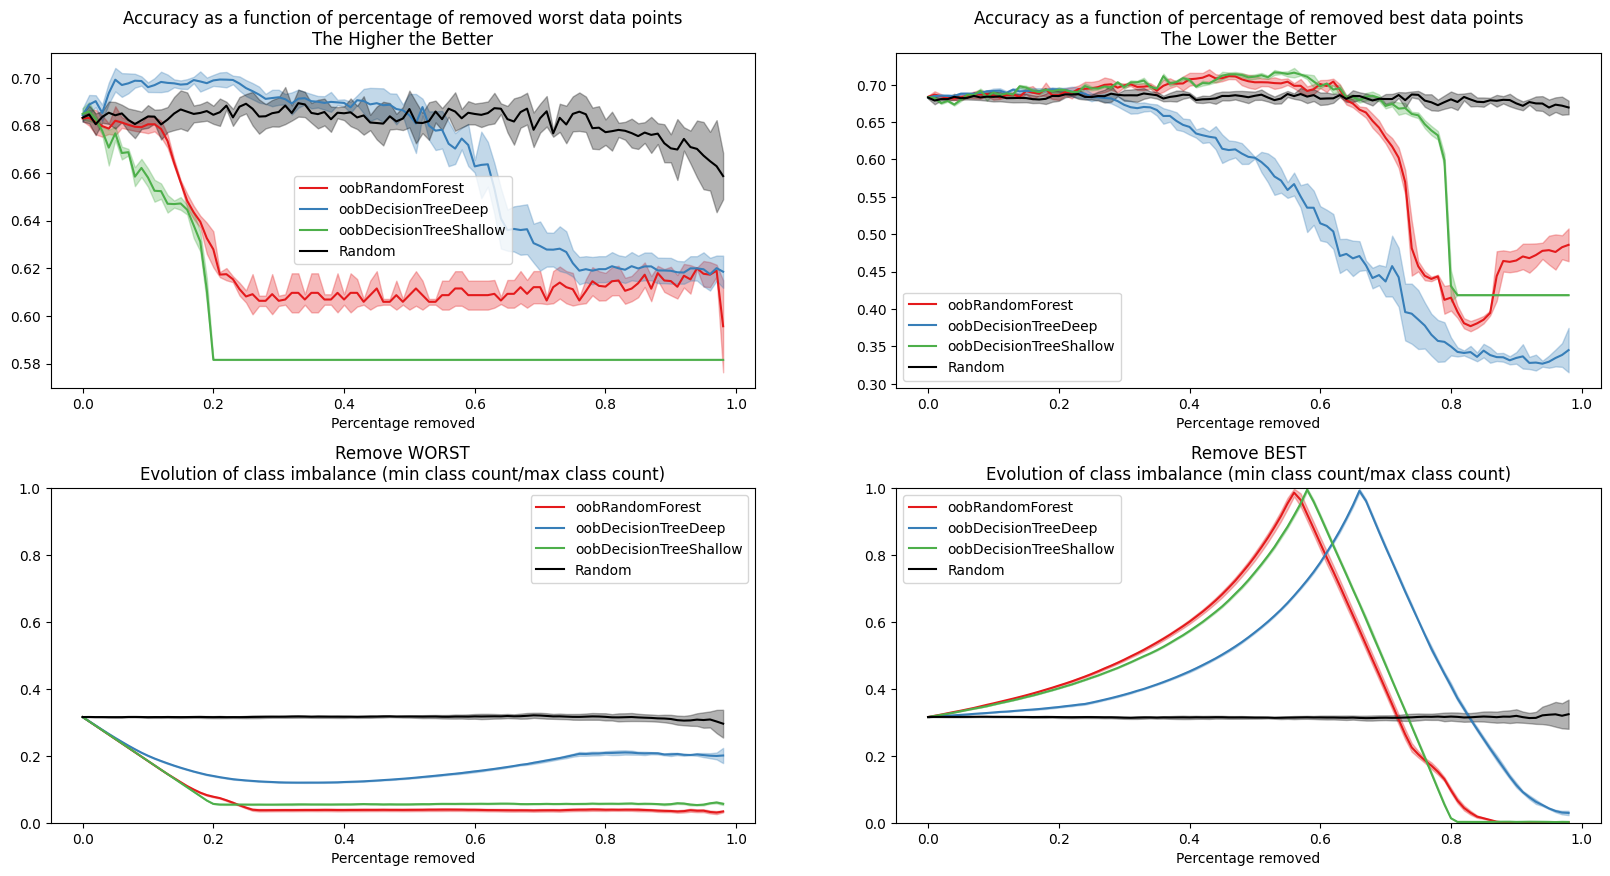

In [ ]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="Set1", random_run=True)

# Plot best/worst points in data space

In [ ]:
dict_utilities.keys()

dict_keys(['DecisionTreeShallow', 'DecisionTreeDeep', 'RandomForest'])

In [ ]:
from sklearn.decomposition import PCA

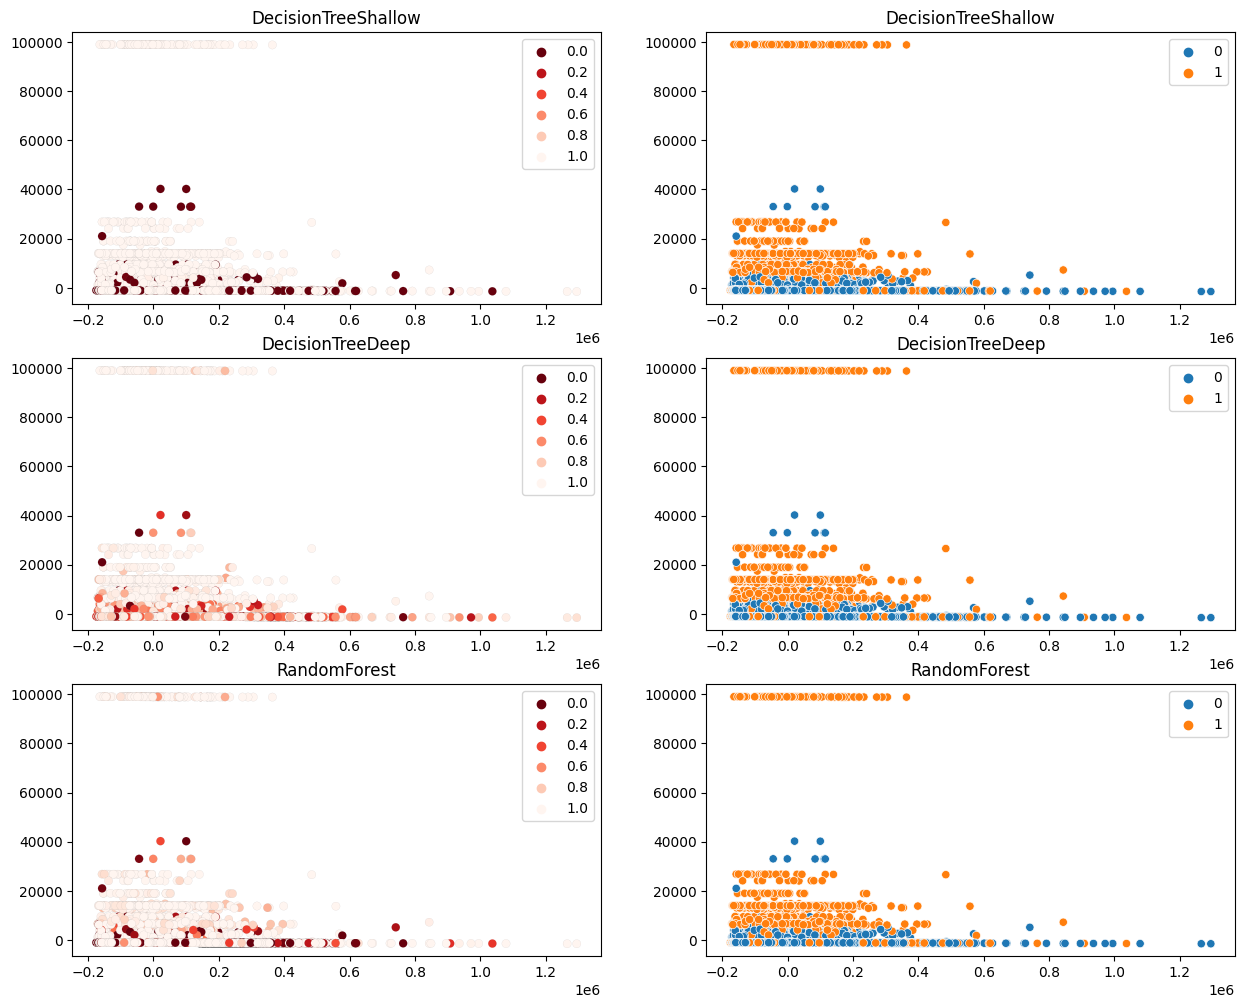

In [ ]:
df = pd.DataFrame(index=utility.data.indices, data=utility.data.x_train, columns=utility.data.feature_names)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df)

fig, ax = plt.subplots(nrows=len(dict_utilities.keys()), ncols=2, figsize= [15,4*len(dict_utilities.keys())])

from sklearn.decomposition import PCA
for i, model_name in enumerate(dict_utilities.keys()):
    vals = compute_data_oob(dict_utilities[model_name], n_est=100, max_samples=0.8, progress=False)
    ax[i,0].set_title(model_name)
    ax[i,1].set_title(model_name)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=vals.values[vals.indices], palette="Reds_r", linewidth=0.05, edgecolor='grey', ax=ax[i,0])
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=utility.data.y_train[utility.data.indices], palette="tab10", ax=ax[i,1])

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
df = pd.DataFrame(index=utility.data.indices, data=utility.data.x_train, columns=utility.data.feature_names)
df.nunique()

x1       73
x2    18407
x3       16
x4      118
x5       89
x6       94
dtype: int64

In [ ]:
utility.data.feature_names

['x1', 'x2', 'x3', 'x4', 'x5', 'x6']

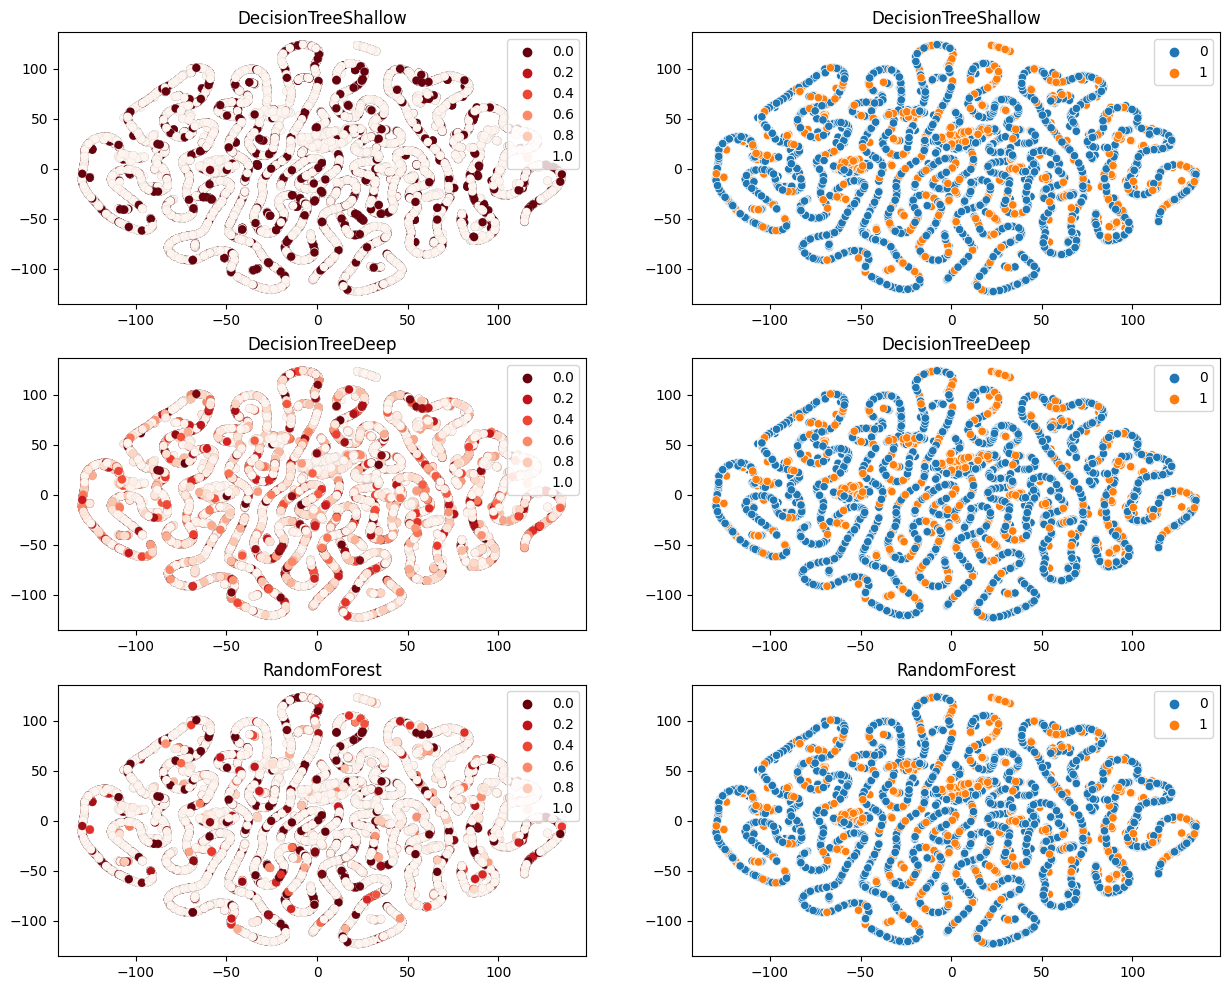

In [ ]:
df = pd.DataFrame(index=utility.data.indices, data=utility.data.x_train, columns=utility.data.feature_names)

tsne = TSNE(n_components=2)
X_pca = tsne.fit_transform(df)
fig, ax = plt.subplots(nrows=len(dict_utilities.keys()), ncols=2, figsize= [15,4*len(dict_utilities.keys())])

from sklearn.decomposition import PCA
for i, model_name in enumerate(dict_utilities.keys()):
    vals = compute_data_oob(dict_utilities[model_name], n_est=100, max_samples=0.8, progress=False)
    ax[i,0].set_title(model_name)
    ax[i,1].set_title(model_name)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=vals.values[vals.indices], palette="Reds_r", linewidth=0.05, edgecolor='grey', ax=ax[i,0])
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=utility.data.y_train[utility.data.indices], palette="tab10", ax=ax[i,1])

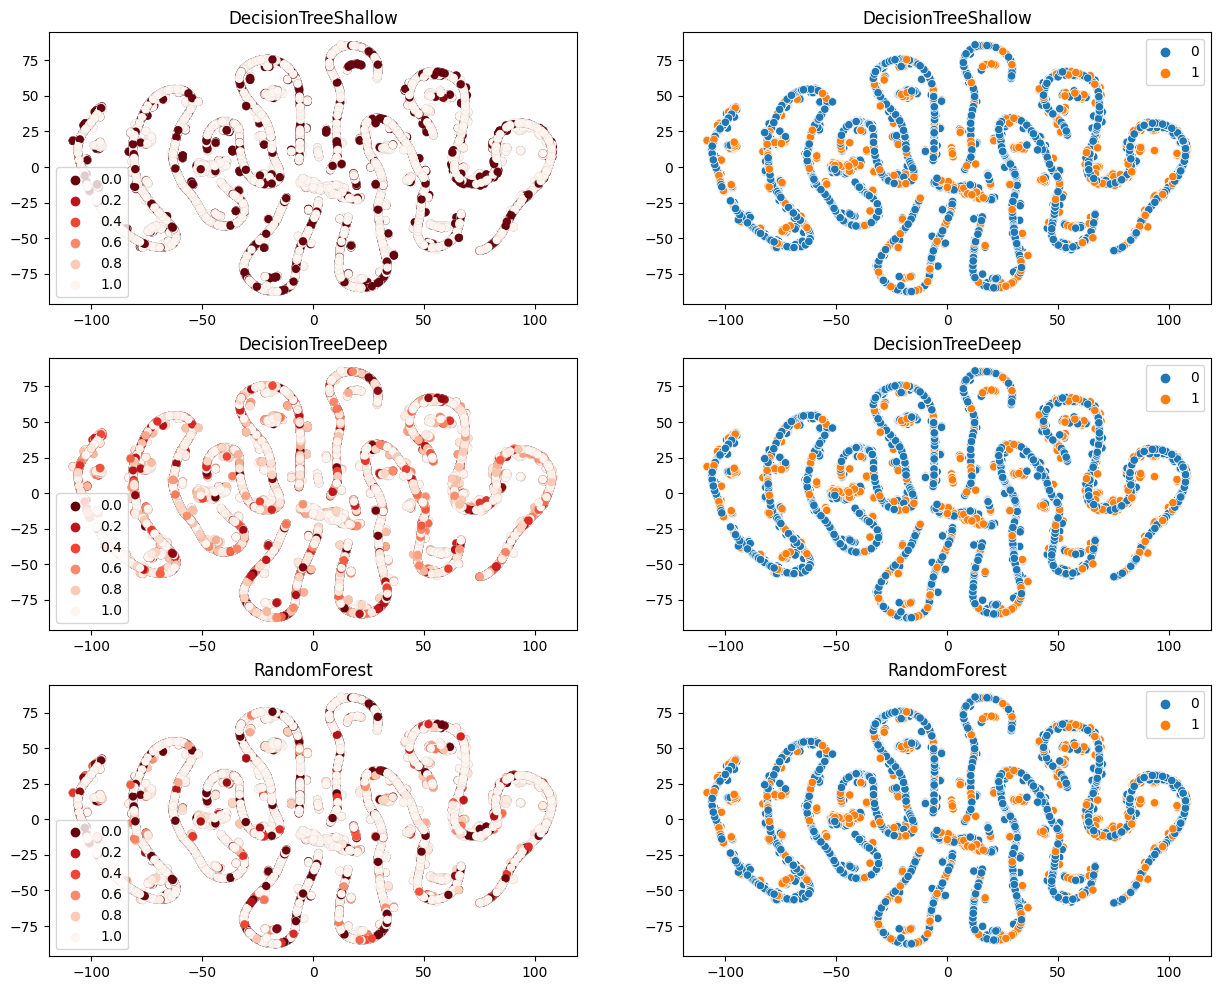

In [ ]:
df = pd.DataFrame(index=utility.data.indices, data=utility.data.x_train, columns=utility.data.feature_names)

tsne = TSNE(n_components=2,perplexity=80)
X_pca = tsne.fit_transform(df)
fig, ax = plt.subplots(nrows=len(dict_utilities.keys()), ncols=2, figsize= [15,4*len(dict_utilities.keys())])

from sklearn.decomposition import PCA
for i, model_name in enumerate(dict_utilities.keys()):
    vals = compute_data_oob(dict_utilities[model_name], n_est=100, max_samples=0.8, progress=False)
    ax[i,0].set_title(model_name)
    ax[i,1].set_title(model_name)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=vals.values[vals.indices], palette="Reds_r", linewidth=0.05, edgecolor='grey', ax=ax[i,0])
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=utility.data.y_train[utility.data.indices], palette="tab10", ax=ax[i,1])

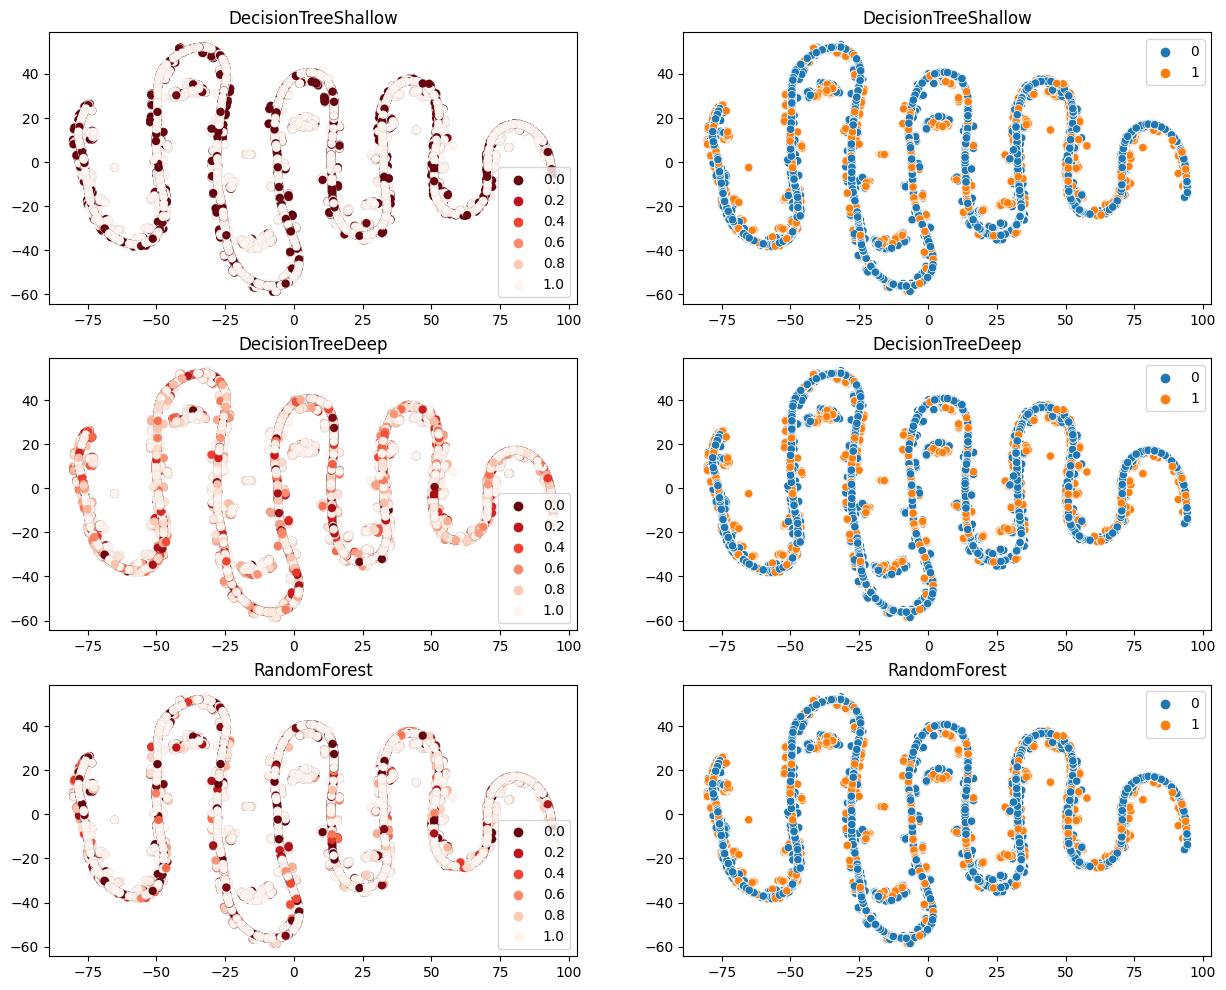

In [ ]:
df = pd.DataFrame(index=utility.data.indices, data=utility.data.x_train, columns=utility.data.feature_names)

tsne = TSNE(n_components=2,perplexity=200)
X_pca = tsne.fit_transform(df)
fig, ax = plt.subplots(nrows=len(dict_utilities.keys()), ncols=2, figsize= [15,4*len(dict_utilities.keys())])

from sklearn.decomposition import PCA
for i, model_name in enumerate(dict_utilities.keys()):
    vals = compute_data_oob(dict_utilities[model_name], n_est=100, max_samples=0.8, progress=False)
    ax[i,0].set_title(model_name)
    ax[i,1].set_title(model_name)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=vals.values[vals.indices], palette="Reds_r", linewidth=0.05, edgecolor='grey', ax=ax[i,0])
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=utility.data.y_train[utility.data.indices], palette="tab10", ax=ax[i,1])